**Electrochemical formation of copper phosphide from aqueous solutions of Cu(II) and hypophosphite ions**

Daniel Torres$^1$, Ronald Vargas $^{1,2,*}$, Lorean Madriz$^{1,3}$ and Bemjamín R. Scharifker$^{1,4,*}$.

$^1$Departamento de Química, Universidad Simón Bolívar (USB), Apartado 89000, Caracas (1080A), Venezuela.

$^2$Instituto Tecnológico de Chascomús (INTECH). Universidad Nacional de San Martín (UNSAM). Consejo Nacional de Investigaciones Científicas y Técnicas (CONICET). Avenida Intendente Marino, Km 8,2, (B7130IWA), Chascomús, Provincia de Buenos Aires, Argentina.

$^3$Instituto de Investigaciones Fisicoquímicas Teóricas y Aplicadas (INIFTA), CCT-La Plata-CONICET, Universidad Nacional de La Plata (UNLP), Diag 113 y 64, La Plata, Argentina.

$^4$Rectorado, Universidad Metropolitana (UNIMET), Apartado 76819, Caracas (1070A), Venezuela.
 

$^*$Corresponding authors: Tel.: +582129063968, E-mail: benjamin@usb.ve and ronaldvargas@usb.ve 



The following Jupyter notebook contains the scripts, written in Python 3.8, that were used for the transient analysis according to equation (4), calculating zp as defined on equation (8) to find the solution of the system of equations (9), as well as calculation of Nsi (10) as seen in the research paper. 

Data for analysis are contained in the files "280mV.csv" and "280mV-Cu.csv" corresponding to current transient registered at 280 mV vs. Cu/Cu$^{2+}$  in the presence and  absence of hypophosphite, respectively.

The file called "supplementary_material_algorithm.ipynb" contains the Python scripts that reads the data files and performs the calculations. Below are its content and results.

#### Necessary packages to run the scripts

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize,integrate
from scipy.optimize import curve_fit

## parameters

In [3]:
#Cu
z1=2
Dcu=3.80586407347027E-06
x1=0.5
v1=7.0921875
#HP
z2=1
x2=0.5
Dhp=0.00001225
v2=20.31318681
F=96485
c=0.00004
gamma=1
Dw=(z1*Dcu*gamma +z2*Dhp)/(gamma*(z1*x1+z2*x2))
Da=(gamma*Dcu+Dhp)/(gamma+1)
k=np.sqrt(8*np.pi*c*(0.977*v1+0.023*v2)/(gamma*(z1*0.977+z2*0.023)*(1+gamma)))
a= Dw*F*c/(np.pi*Da)**0.5
area = 0.21
print(f'Dw={Dw},Da={Da},k={k}')

Dw=1.3241152097960361e-05,Da=8.027932036735135e-06,k=0.04336486368571909


In [4]:
#Cu2+ 0.04M + H2PO2- 0.04M, at 280mV
CuP280 = pd.read_csv("280mV.csv",header=0,sep='[,:]',engine='python')
xhp = CuP280["T"]
yhp = CuP280["i"].apply(lambda x: x*1000/(-area))

#Cu2+ 0.04M, at 280mV
Cu280 = pd.read_csv("280mV-Cu.csv",header=0,sep='[,:]',engine='python')
xCu = Cu280['T']
yCu = Cu280['i'].apply(lambda x: x*1000/(-area))

## current transients analysis

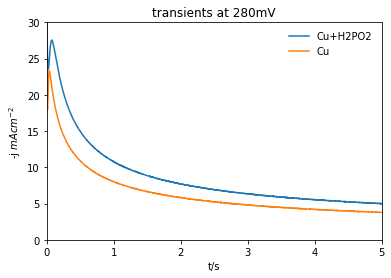

In [5]:
ax = plt.axes()
ax.plot(xhp,yhp,label='Cu+H2PO2')
ax.plot(xCu,yCu, label='Cu')
ax.set(ylim=(0, 30), xlim=(0,5),
       xlabel='t/s',ylabel='-j $mAcm^{-2}$',
       title='transients at 280mV');
ax.legend(loc='upper right', frameon=False, fontsize=10)
plt.show()

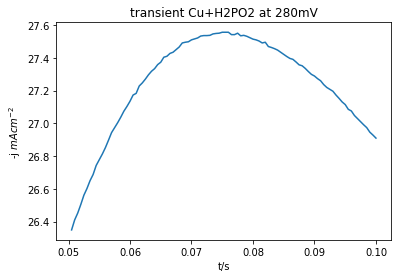

i_max = 0.027556333333333335 and t_max = 0.075 for Cu+H2PO2 at 280 mV


In [6]:
ax = plt.axes()
ax.plot(xhp.iloc[100:200],yhp.iloc[100:200])
i_max=yhp.iloc[100:200].max()/1000
t_max =CuP280[yhp == i_max*1000]['T'].iloc[0]
ax.set(xlabel='t/s',ylabel='-j $mAcm^{-2}$',
       title='transient Cu+H2PO2 at 280mV');
plt.show()
print(f'i_max = {i_max} and t_max = {t_max} for Cu+H2PO2 at 280 mV')

### system of transcendental equations 

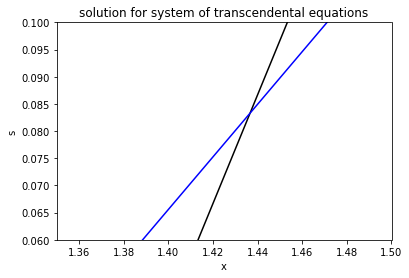

In [7]:
def ec1(x,s):
    return np.log(1-((i_max*t_max**0.5)/a))+x-s*(1-np.exp(-x/s))

def ec2(x,s):
    return np.log(1+2*x*(1-np.exp(-x/s)))-x + s*(1-np.exp(-x/s))

x=np.linspace(0.000001, 15,num=100)
s=np.linspace(0.000001, 10,num=100)
X,Y = np.meshgrid(x, s)
Z1= ec1(X,Y)
Z2= ec2(X,Y)

ax = plt.axes()
ax.contour(X,Y,Z1,[0], colors='black')
ax.contour(X,Y,Z2,[0], colors='blue')
ax.set(xlabel='x',ylabel='s',xlim=(1.35,1.5),ylim=(0.06,0.10),
      title='solution for system of transcendental equations')
plt.show()

In [8]:
def system(args):
    x=args[0]
    s=args[1]
    return [np.log(1-((i_max*t_max**0.5)/a))+x-s*(1-np.exp(-x/s)),
       np.log(1+2*x*(1-np.exp(-x/s)))-x + s*(1-np.exp(-x/s))]

initial_guess=[1.44,0.09]

#minimization using Levenberg–Marquardt algorithm
root=optimize.root(system,initial_guess, method='lm')

x,s=root.x
N0=x/(np.pi*k*(Da**0.5)*(Dw**0.5)*t_max)
A=(N0*np.pi*k*(Da**0.5)*(Dw**0.5))/s
print(f'x={x},s={s}, N0={N0}, A={A}')

x=1.4351578793636632,s=0.08182180411307736, N0=13623410.011465028, A=233.86722645555972


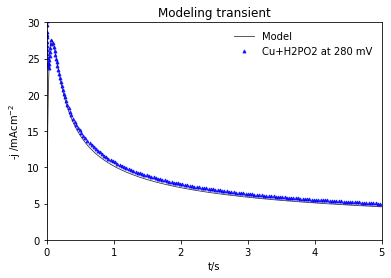

In [9]:
t = np.linspace(0.00005,5,1000)
model = Dw*F*c/(np.sqrt(np.pi*Da*t))*(1-np.exp(-N0*np.pi*k*np.sqrt(Da*Dw)*(t-((1-np.exp(-A*t))/A))))

ax = plt.axes()
ax.plot(t, model*(1000), color="black",alpha=0.8,
        linewidth=0.8, linestyle="-",label="Model")
ax.plot(xhp, yhp, color='blue',alpha=0.8,
        linewidth=0.1,linestyle="None",marker='^', 
        markersize=3,markevery =0.01,label='Cu+H2PO2 at 280 mV')

ax.set(xlabel='t/s',ylabel=r'-j /mAcm$^{-2}$', xlim=(0,5), ylim=(0,30),
       title='Modeling transient')
ax.legend(loc='upper right', frameon=False, fontsize=10)
plt.show()

### the saturation number density of nuclei: Ns

In [10]:
def integral(u):
    return np.exp(-N0*np.pi*k*np.sqrt(Dw)*np.sqrt(Da)*
                  (A*u-1-np.exp(-A*u))/A)*np.exp(-A*u)

area= integrate.quad(integral,0,30)
Ns=A*N0*area[0]
print(f'integral={area[0]},Ns={Ns}')

integral=0.004477061212917151,Ns=14264226.453074059


### Cottrell analysis

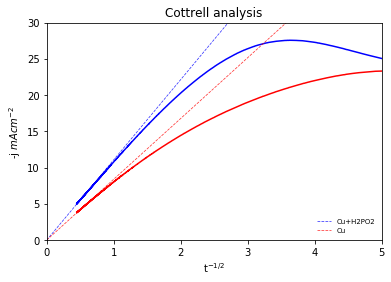

In [11]:
#data
xp_Cottrell = xhp.apply(lambda x: x**(-0.5) )
x_Cottrell = xCu.apply(lambda x: x**(-0.5) )
ax = plt.axes()
#fit trend 
def poly(x,a):
    return x*a

slope_p=curve_fit(poly, xp_Cottrell.iloc[7000:8500], yhp.iloc[7000:8500])[0]
slope_cu=curve_fit(poly, x_Cottrell.iloc[7000:8500], yCu.iloc[7000:8500])[0]
poly_x =np.linspace(0.00000, 5,num=100)

#data
ax.plot(xp_Cottrell, yhp,color='blue')
ax.plot(x_Cottrell, yCu, color='red')
#fit trend
ax.plot(poly_x,slope_p*poly_x,color="blue",alpha=0.8,linewidth=0.75,
        linestyle="--", label='Cu+H2PO2')
ax.plot(poly_x,slope_cu*poly_x,color="red",alpha=0.8,linewidth=0.75,
        linestyle="--",label='Cu')
ax.legend(loc='lower right', frameon=False, fontsize=7)
ax.set(xlabel='t$^{-1/2}$',ylabel='-j $mAcm^{-2}$',xlim=(0,5), ylim=(0,30),
       title='Cottrell analysis')
plt.show()

In [12]:
jj=slope_p/slope_cu
zp=int((z1*gamma*(jj*z1*np.sqrt(Dcu*Da)*x1-Dcu))/
       (Dhp-jj*z1*np.sqrt(Dcu*Da)*gamma*x2))

Dapp=(Dw/Da**0.5)**2
Dexp= (slope_p*np.pi**0.5/(F*1000*c))**2
print(f'zp={zp},Dapp={Dapp},Dexp={Dexp}')

zp=1,Dapp=2.1839759987881508e-05,Dexp=[2.58162763e-05]


### non-dimensional anlysis

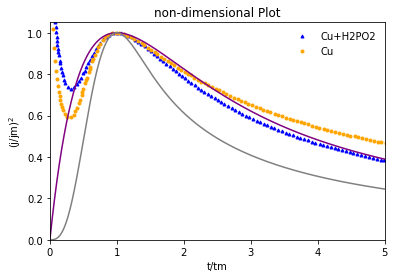

In [13]:
ta = np.linspace(0.00001,5,1000)
inst= (1.9542/ta)*(1-np.exp(-1.2564*ta))**2
prog=(1.2254/ta)*(1-np.exp(-2.3367*ta**2))**2

adidata = pd.DataFrame()
adidata['t/tm']=xhp.apply(lambda x:x/t_max)
adidata['i/im']=yhp.apply(lambda x:(x/(i_max*1000))**2)

i_maxCu=yCu.iloc[20:200].max()/1000
t_maxCu=Cu280[yCu == i_maxCu*1000]['T'].iloc[0]
adidataCu = pd.DataFrame()
adidataCu['t/tm']=xCu.apply(lambda x:x/t_maxCu)
adidataCu['i/im']=yCu.apply(lambda x:(x/(i_maxCu*1000))**2)

ax = plt.axes()
ax.plot(adidata['t/tm'], adidata['i/im'], color='blue',alpha=1,
        linewidth=0.1,linestyle="None",marker='^',
        markersize=3,markevery =0.01,Label='Cu+H2PO2')
ax.plot(adidataCu['t/tm'], adidataCu['i/im'], color='orange',alpha=1,
        linewidth=0.1,linestyle="None",marker='o', 
        markersize=3,markevery =0.01,label="Cu")

ax.plot(ta,inst,color='purple')
ax.plot(ta,prog,color='gray')
ax.set(xlim=(0,5),ylim=(0,1.05),ylabel='(j/jm)$^{2}$',
       xlabel='t/tm', title= 'non-dimensional Plot')
ax.legend(loc='best', frameon=False, fontsize=10)
plt.show()